In [5]:
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import patches as mpatches
import matplotlib.cm as cm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import natural_earth
import shapefile
import numpy as np
import pandas as pd
from glob import glob
import xarray as xr
from scipy.ndimage import gaussian_filter

from datetime import datetime
import metpy
from metpy.units import units
from ptype.plotting import get_tle_files, plot_ptype, plot_hrrr_ptype, load_data

In [6]:
valid_time = '2023-12-26 0100'
base_path = '/glade/campaign/cisl/aiml/ptype_historical/winter_2023_2024_extended/no_winds/hrrr'
n_members = 18

files = get_tle_files(base_path, valid_time, n_members)

In [7]:
def load_ensemble(files):
    ptypes = ['rain', 'snow', 'icep', 'frzr']
    ds = xr.open_mfdataset(files, parallel=True)
    #variables = ['ML_rain', 'ML_snow', 'ML_frzr', 'ML_icep', 'ML_cicep', 'ML_cfrzr', 'ML_crain', 'ML_csnow', 'csnow', 'crain', 'cicep', 'cfrzr', 't_h']
    
    #ds = ds[variables]
    vars = []
    
    precip_sum = ds[['crain', 'csnow', 'cicep', 'cfrzr']].to_array().sum(dim='variable')
    for ptype in ptypes:
        ds[f'ML_{ptype}'] = xr.where(precip_sum >= 1, x=ds[f'ML_{ptype}'], y=0)
        ds[f'ML_{ptype}_epi'] = xr.where(precip_sum >= 1, x=ds[f"ML_{ptype}_epi"], y=0)
        ds[f'ML_{ptype}_ale'] = xr.where(precip_sum >= 1, x=ds[f"ML_{ptype}_ale"], y=0)
        vars.append(f'ML_{ptype}')
        vars.append(f'ML_{ptype}_epi')
        vars.append(f'ML_{ptype}_ale')

    ds['t2m_mean'] = xr.where(precip_sum >= 1, x=ds['t2m'], y=np.nan)
    vars.append('t2m_mean')
    ds['d2m_mean'] = xr.where(precip_sum >= 1, x=ds['d2m'], y=np.nan)
    vars.append('d2m_mean')
    
    ptype_hier = ['frzr', 'icep', 'snow', 'rain']
    concat = xr.concat([ds[f'ML_{ptype}'] for ptype in ptype_hier], dim='ptype')
    concat_tle = concat.mean("time")
    max_idx = concat_tle.argmax(dim='ptype')

    concat_hrrr = xr.concat([ds[f'c{ptype}'] for ptype in ptype_hier], dim='ptype')
    concat_hrrr_tle = concat_hrrr.mean("time")
    max_idx_tle = concat_hrrr_tle.argmax(dim='ptype')

    for i, ptype in enumerate(ptype_hier):
        ds[f'ML_c{ptype}'] = xr.where(max_idx == i, 1, np.nan)  # set categorical values
        ds[ptype] = ds[f'ML_c{ptype}'] * ds[f'ML_{ptype}']  # set categorical scaled by probability
        ds[f'c{ptype}'] = xr.where((max_idx_tle == i) & (concat_hrrr_tle[i] != 0), concat_hrrr_tle[i], np.nan)
        vars.append(f'ML_c{ptype}')
        vars.append(f'c{ptype}')
        vars.append(ptype)

    #ds = ds[vars].mean("time").apply(lambda x: x.where(x != 0, np.nan))  # average and set 0 to nan in one line
    #ds = ds.mean("time")
    mask = precip_sum.mean("time") <= 0
    
    ds_changed = ds[vars].mean("time").where(~mask) # only mean the selected variables
    ds = ds.update(ds_changed)

    return ds

In [10]:
data = load_ensemble(files)

In [32]:
data

<xarray.Dataset> Size: 9GB
Dimensions:            (time: 18, heightAboveGround: 21, y: 487, x: 732,
                        isobaricInhPa: 40)
Coordinates:
  * heightAboveGround  (heightAboveGround) int64 168B 0 250 500 ... 4750 5000
  * time               (time) datetime64[ns] 144B 2023-12-25T07:00:00 ... 202...
    step               (time) timedelta64[ns] 144B 18:00:00 ... 01:00:00
  * isobaricInhPa      (isobaricInhPa) float32 160B 1.013e+03 1e+03 ... 50.0
    latitude           (y, x) float32 1MB dask.array<chunksize=(487, 732), meta=np.ndarray>
    longitude          (y, x) float32 1MB dask.array<chunksize=(487, 732), meta=np.ndarray>
    valid_time         datetime64[ns] 8B 2023-12-26T01:00:00
    atmosphere         float32 4B 0.0
Dimensions without coordinates: y, x
Data variables: (12/44)
    t_h                (time, heightAboveGround, y, x) float32 539MB dask.array<chunksize=(1, 11, 244, 366), meta=np.ndarray>
    dpt_h              (time, heightAboveGround, y, x) float32 539MB dask.array<chunksize=(1, 11, 244, 366), meta=np.ndarray>
    isobaricInhPa_h    (time, heightAboveGround, y, x) float64 1GB dask.array<chunksize=(1, 11, 244, 366), meta=np.ndarray>
    t                  (time, isobaricInhPa, y, x) float32 1GB dask.array<chunksize=(1, 20, 244, 366), meta=np.ndarray>
    u                  (time, isobaricInhPa, y, x) float32 1GB dask.array<chunksize=(1, 20, 244, 366), meta=np.ndarray>
    v                  (time, isobaricInhPa, y, x) float32 1GB dask.array<chunksize=(1, 20, 244, 366), meta=np.ndarray>
    ...                 ...
    t2m_mean           (y, x) float32 1MB dask.array<chunksize=(487, 732), meta=np.ndarray>
    d2m_mean           (y, x) float32 1MB dask.array<chunksize=(487, 732), meta=np.ndarray>
    frzr               (y, x) float64 3MB dask.array<chunksize=(487, 732), meta=np.ndarray>
    icep               (y, x) float64 3MB dask.array<chunksize=(487, 732), meta=np.ndarray>
    snow               (y, x) float64 3MB dask.array<chunksize=(487, 732), meta=np.ndarray>
    rain               (y, x) float64 3MB dask.array<chunksize=(487, 732), meta=np.ndarray>

In [14]:
def plot_background(ax, extent=[-107, -85.5, 36, 49]):
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    return ax

In [11]:
def contour_temp(ax, lon, lat, data, color='white'):
    min = np.nanmin(data)
    max = np.nanmax(data)
    levels = np.arange(np.floor(min), np.ceil(max), 2)  # Contours at every 2 degrees
    
    # Create contour levels for positive and negative temperatures separately
    pos_levels = levels[levels > 0]
    neg_levels = levels[levels < 0]
    
    # Plot positive temperature contours
    if len(pos_levels) > 0:
        pos_contours = ax.contour(lon, lat, data, levels=pos_levels, transform=ccrs.PlateCarree(), colors=color, linewidths=1)
        ax.clabel(pos_contours, fontsize=10, colors=color)
    
    # Plot negative temperature contours with dashed lines
    if len(neg_levels) > 0:
        neg_contours = ax.contour(lon, lat, data, levels=neg_levels, transform=ccrs.PlateCarree(), colors=color, linewidths=1, linestyles='dashed')
        ax.clabel(neg_contours, fontsize=10, colors=color)

    # Plot zero-degree line as dashed line
    zero_contour = ax.contour(lon, lat, data, levels=[0], transform=ccrs.PlateCarree(), colors=color, linestyles='dashed', linewidths=2)
    ax.clabel(zero_contour, fmt='%d', colors=color)

    return ax

In [12]:
def plot_case_study(data):
    
    #base_path = '/glade/campaign/cisl/aiml/ptype_historical/winter_2023_2024_extended/no_winds/hrrr'
    #n_members = 18
    #files = get_tle_files(base_path, valid_time, n_members)

    #data = load_ensemble(files)

    crs = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
    fig, ax = plt.subplots(figsize=(20, 13), subplot_kw={'projection': crs})
    plot_background(ax, [-107, -85.5, 36.5, 49])
    
    lat = data['latitude'].values
    lon = data['longitude'].values
    
    # top left: all ptypes:
    custom_colors = ['#f8f4f8', '#f005fc']
    purples = mcolors.LinearSegmentedColormap.from_list("custom", custom_colors)
    cmaps = ['Greens', 'Blues', 'Reds', purples]
    ptypes = ['rain', 'snow', 'frzr', 'icep']
    for i, ptype in enumerate(ptypes):
        h = ax.pcolormesh(lon, lat, data[f'{ptype}'], transform=ccrs.PlateCarree(), cmap=cmaps[i], vmin=0, vmax=1)
    
    plt.rcParams['text.usetex'] = True
    ax.set_title("Precipitation Types, Surface Temp, 10m Winds", fontsize=25)
    
    # Add legend
    legend_handles = [mpatches.Patch(color=plt.get_cmap(cmaps[i])(0.6), label=ptype) for i, ptype in enumerate(ptypes)]
    ax.legend(handles=legend_handles, loc='upper left', title='Precipitation Types', fontsize=20, title_fontsize=22, frameon=True, framealpha=1, fancybox=True)
    
    # add temp contours
    temp_data = data['d2m'].mean("time") - 273.15
    # Apply Gaussian smoothing
    smoothed_temp = gaussian_filter(temp_data, sigma=2)
    contour_temp(ax, lon, lat, smoothed_temp)
    
    # add wind barbs:
    u = data['u10'].mean("time").values
    v = data['v10'].mean("time").values
    ax.barbs(lon[::20, ::20], lat[::20, ::20], u[::20, ::20], v[::20, ::20], length=6, linewidth=1, transform=ccrs.PlateCarree())
    
    plt.tight_layout()
    time = valid_time.replace(" ", "_")
    plt.savefig(f"./plots/{time}_ptype_dew_barb.png", dpi=100)

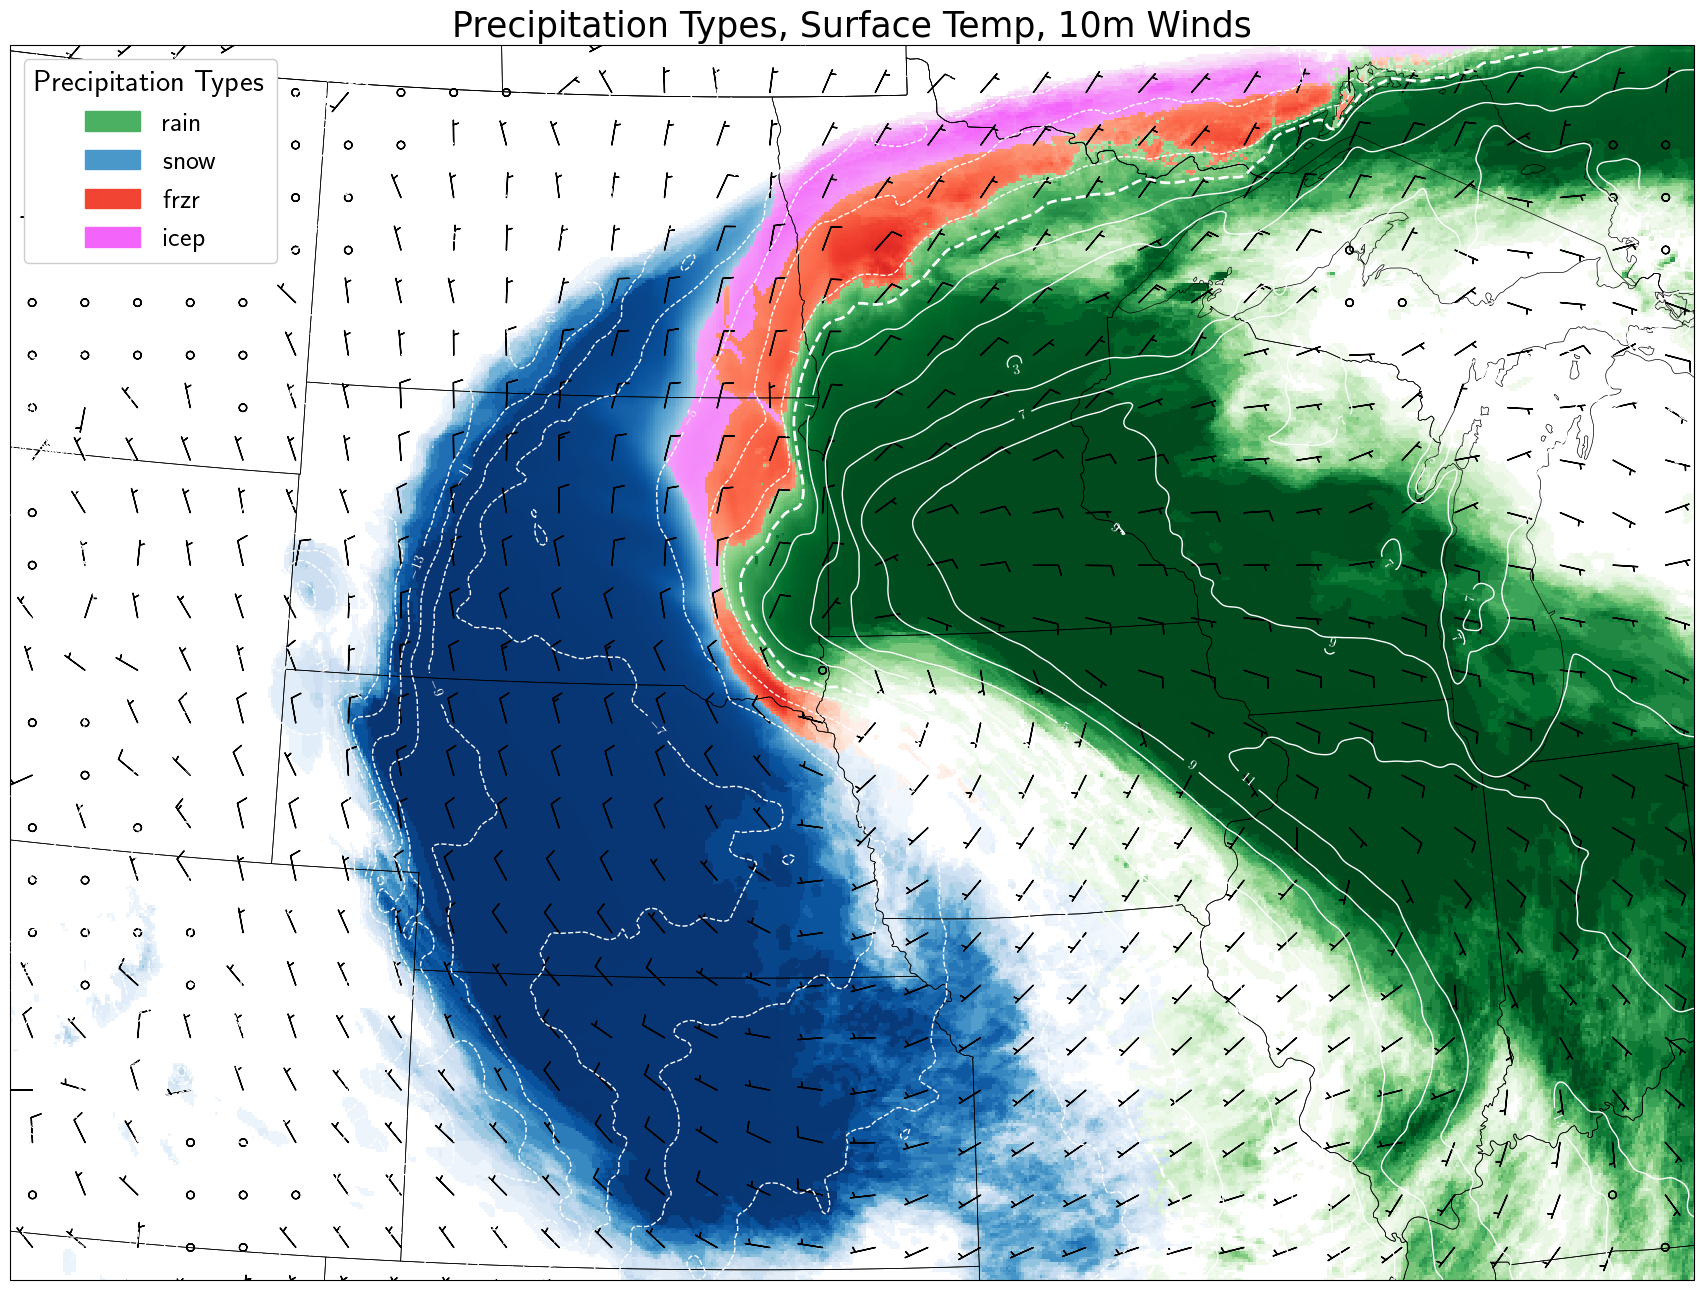

In [15]:
plot_case_study(data)

In [ ]:
time = '2023-12-26'
times = []
for i in range(1, 19):
    j = str(i).zfill(2)
    times.append(f'{time} {j}00')

for t in times:
    plot_case_study(t)

In [21]:
def plot_case_study_hrrr(valid_time):
    
    base_path = '/glade/campaign/cisl/aiml/ptype_historical/winter_2023_2024_extended/no_winds/hrrr'
    n_members = 18
    files = get_tle_files(base_path, valid_time, n_members)

    variables = [
        'u10', 'v10', 'ML_rain', 'ML_crain', 'ML_snow', 'ML_csnow', 'ML_frzr', 'ML_cfrzr', 'ML_icep', 'ML_cicep',
        'crain', 'csnow', 'cfrzr', 'cicep', 'ML_rain_ale', 'ML_rain_epi', 'ML_snow_ale', 'ML_snow_epi', 'ML_frzr_ale',
        'ML_frzr_epi', 'ML_icep_ale', 'ML_icep_epi', 'd2m', 't2m', 'sp'
    ]
    
    data = load_data(files, variables)

    crs = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
    fig, ax = plt.subplots(figsize=(20, 13), subplot_kw={'projection': crs})
    plot_background(ax, [-107, -85.5, 36.5, 49])
    
    lat = data['latitude'].values
    lon = data['longitude'].values
    
    # top left: all ptypes:
    custom_colors = ['#f8f4f8', '#f005fc']
    purples = mcolors.LinearSegmentedColormap.from_list("custom", custom_colors)
    cmaps = ['Greens', 'Blues', 'Reds', purples]
    ptypes = ['rain', 'snow', 'frzr', 'icep']
    for i, ptype in enumerate(ptypes):
        h = ax.pcolormesh(lon, lat, data[f'c{ptype}'], transform=ccrs.PlateCarree(), cmap=cmaps[i], vmin=0, vmax=1)
    
    plt.rcParams['text.usetex'] = True
    ax.set_title("Precipitation Types, Surface Temp, 10m Winds", fontsize=25)
    
    # Add legend
    legend_handles = [mpatches.Patch(color=plt.get_cmap(cmaps[i])(0.6), label=ptype) for i, ptype in enumerate(ptypes)]
    ax.legend(handles=legend_handles, loc='upper left', title='Precipitation Types', fontsize=20, title_fontsize=22, frameon=True, framealpha=1, fancybox=True)
    
    # add temp contours
    temp_data = data['t2m'] - 273.15
    # Apply Gaussian smoothing
    #smoothed_temp = gaussian_filter(temp_data, sigma=2)
    contour_temp(ax, lon, lat, temp_data)
    
    # add wind barbs:
    u = data['u10'].values
    v = data['v10'].values
    ax.barbs(lon[::20, ::20], lat[::20, ::20], u[::20, ::20], v[::20, ::20], length=6, linewidth=1, transform=ccrs.PlateCarree())
    
    plt.tight_layout()
    time = valid_time.replace(" ", "_")
    #plt.savefig(f"./plots/{time}_ptype_temp_barb.png", dpi=100)

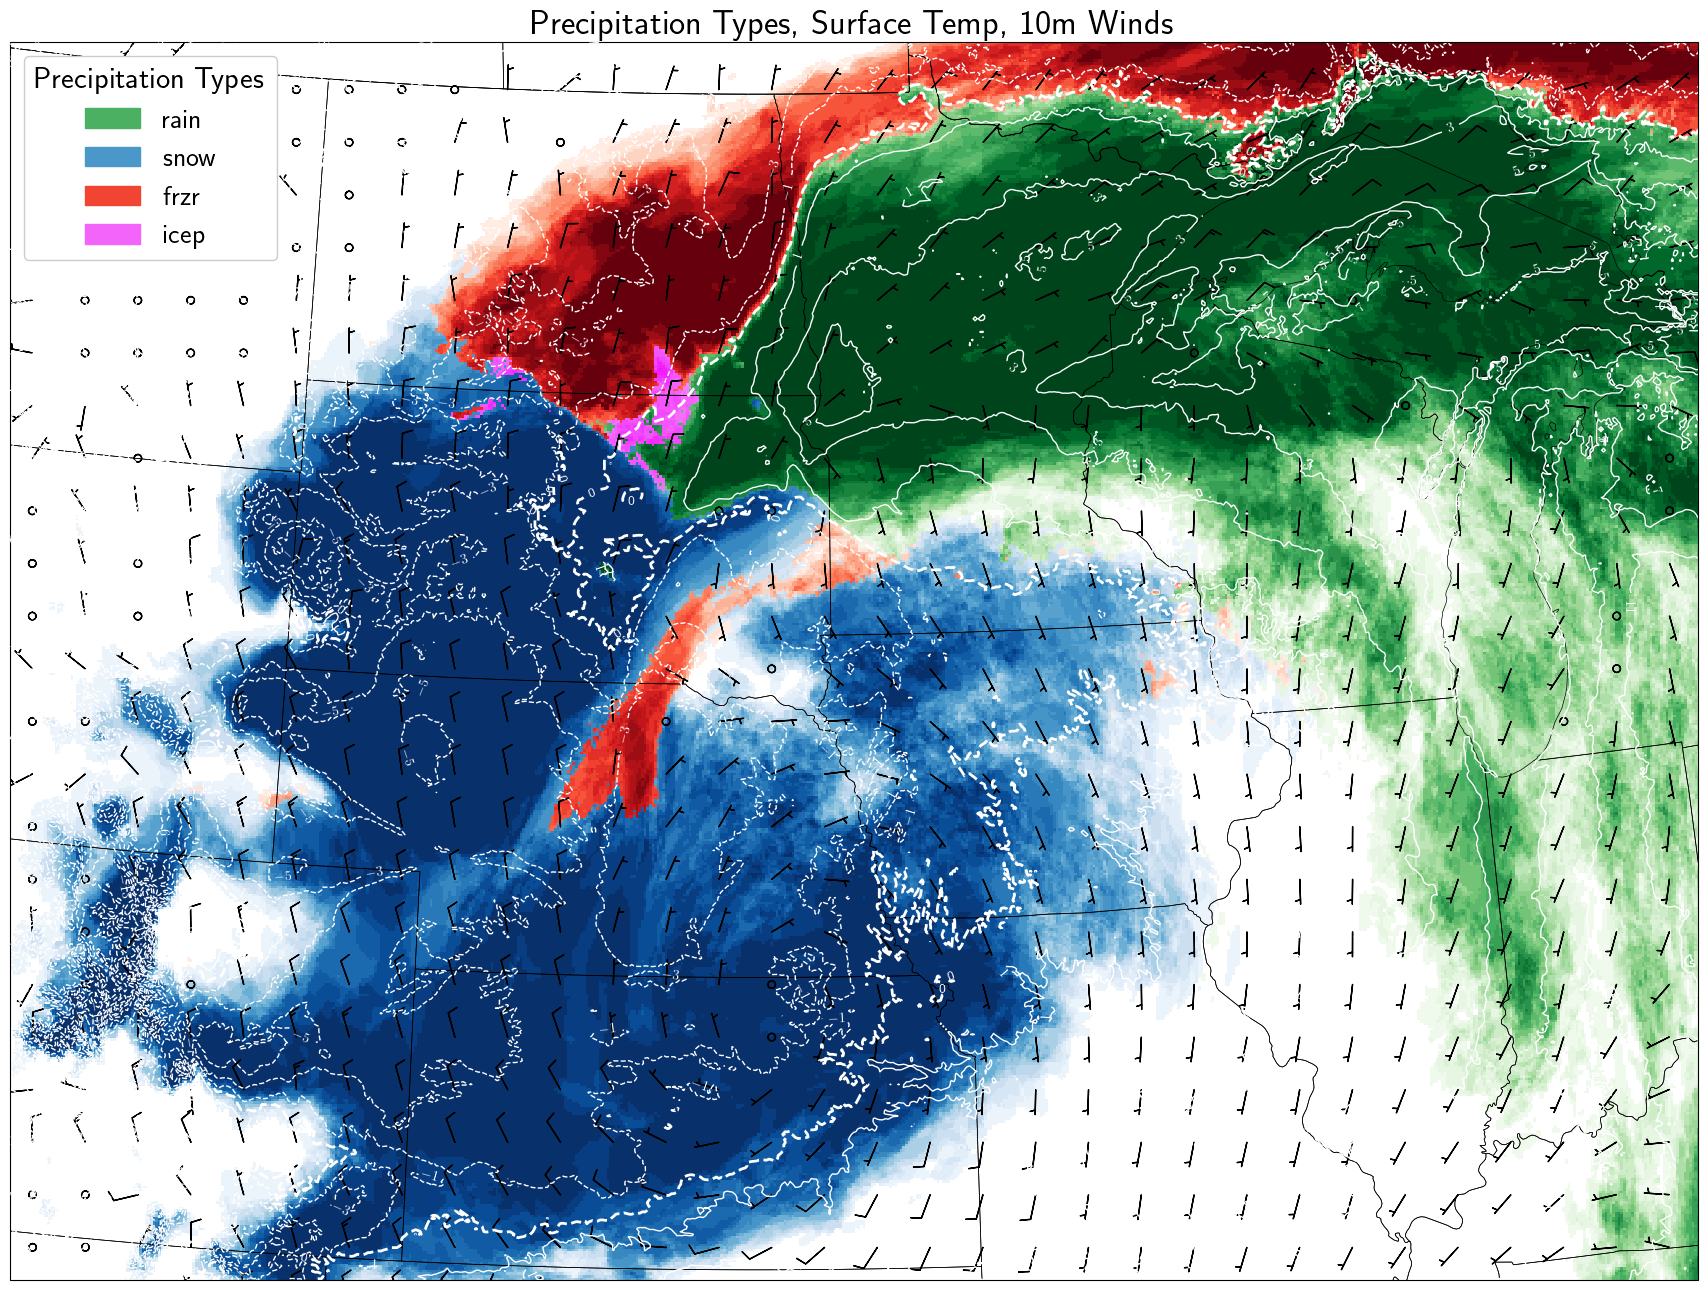

In [22]:
valid_time = '2023-12-26 1700'
plot_case_study_hrrr(valid_time)

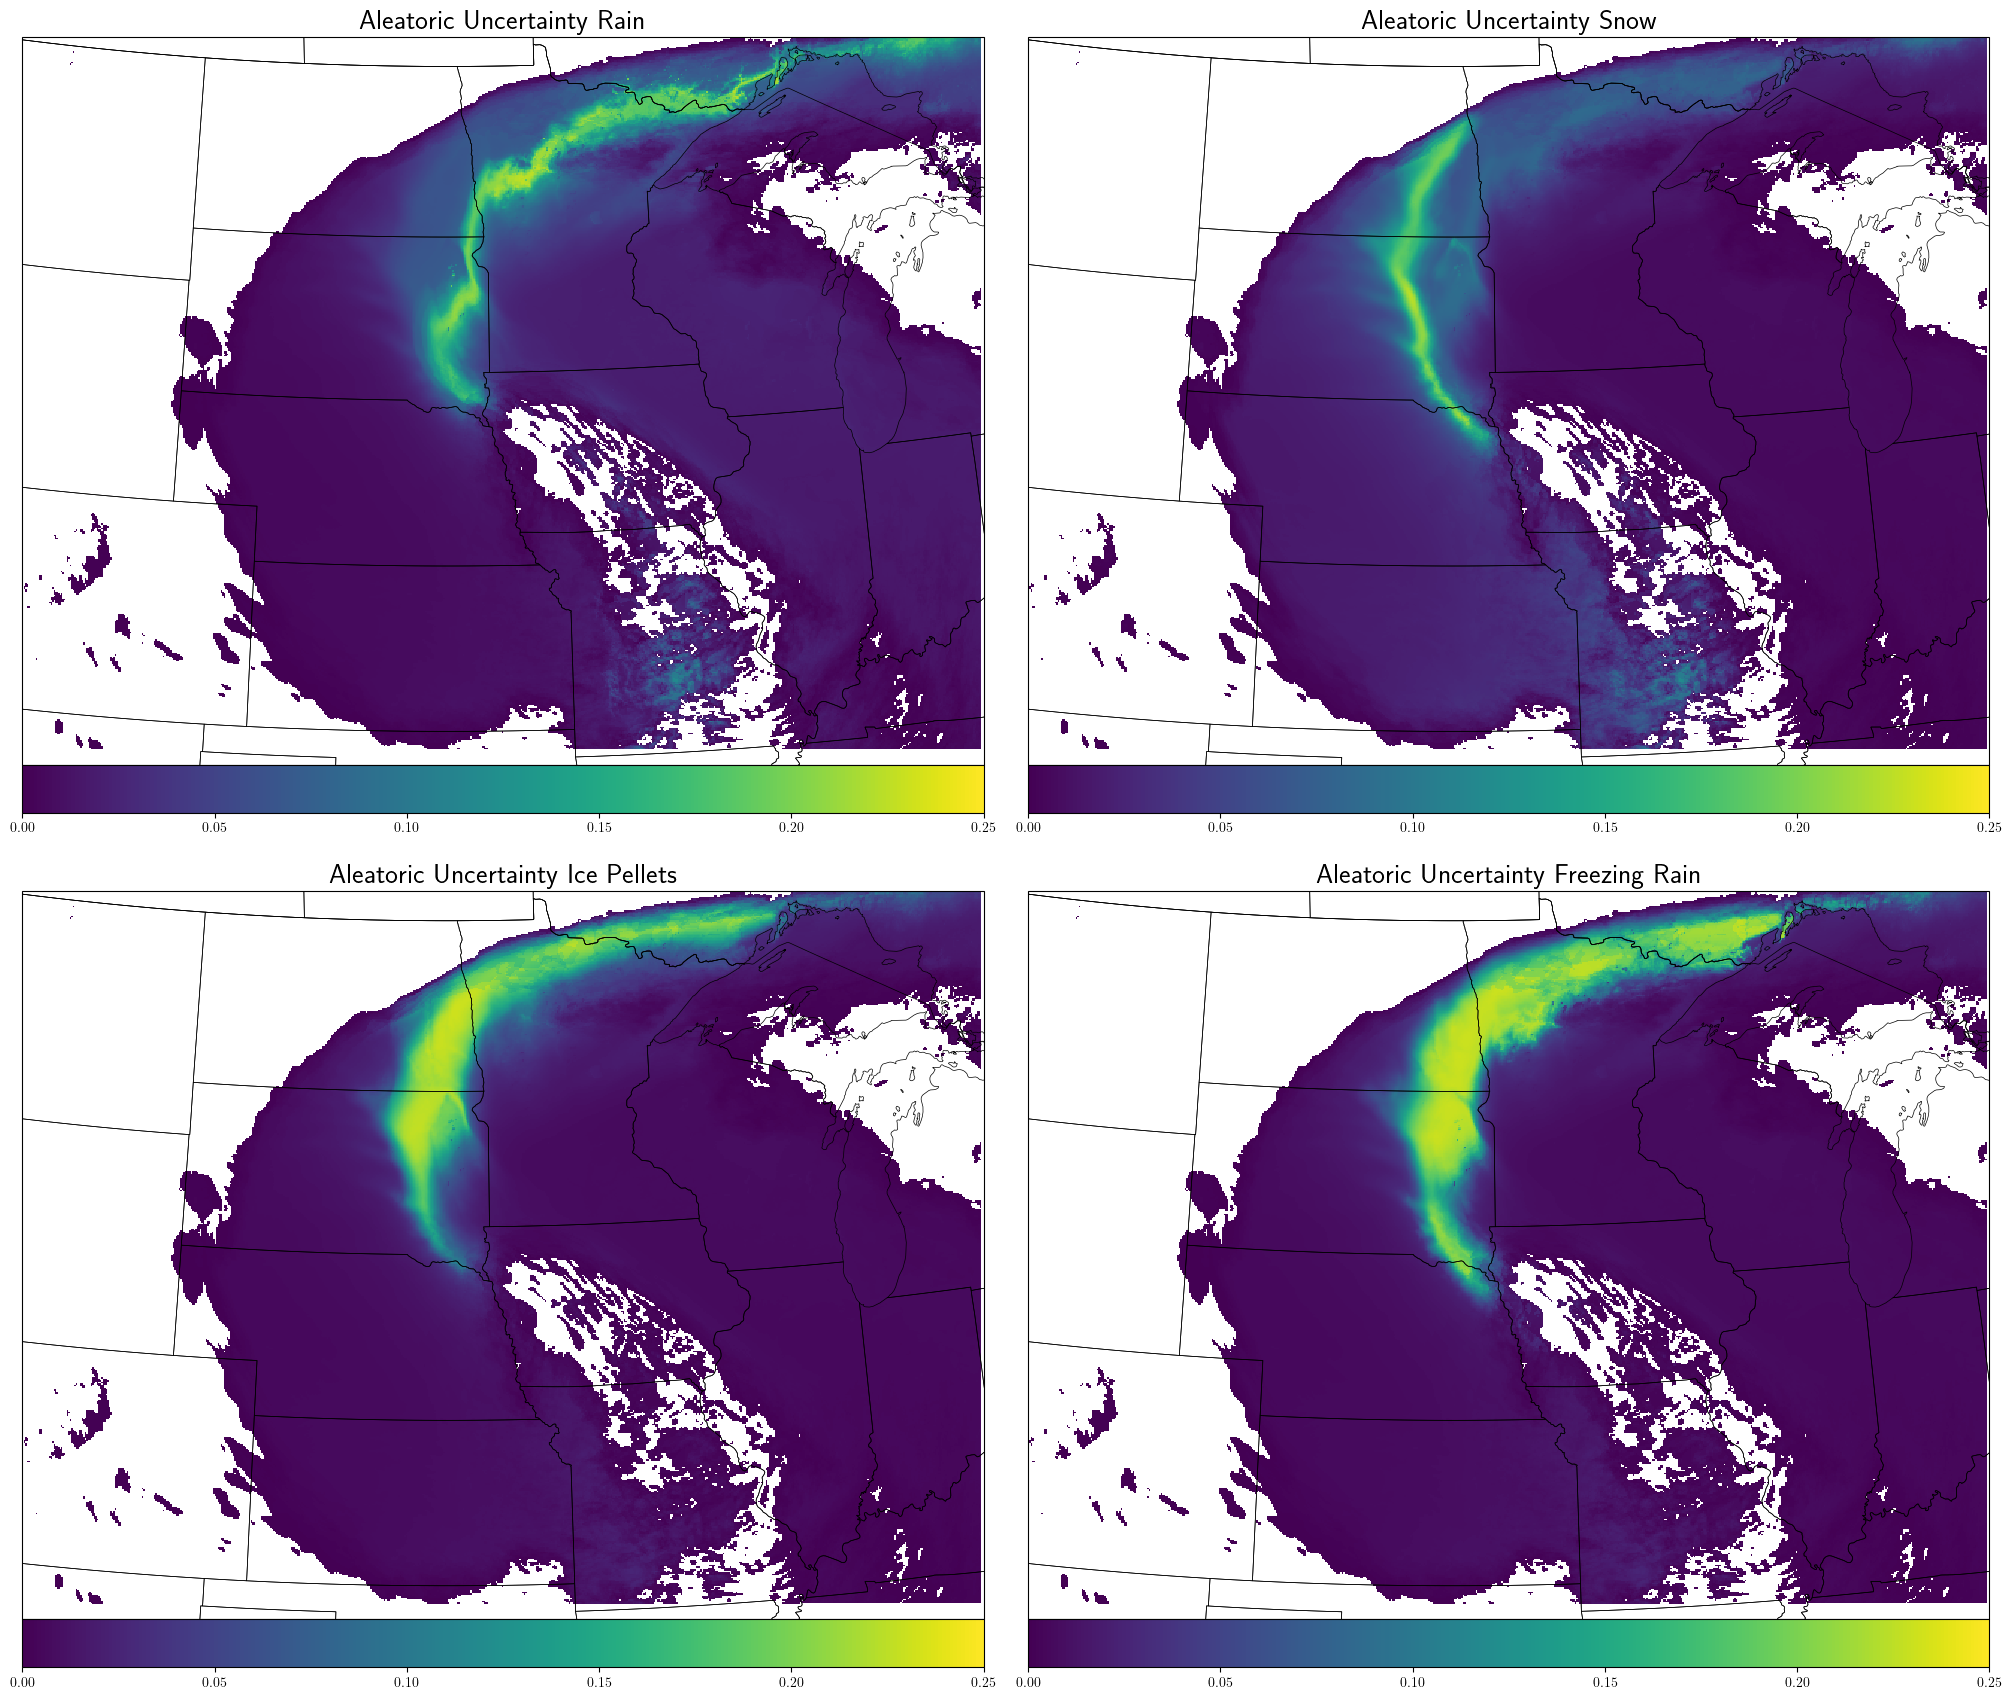

In [39]:
# 4 panel uncertainty plot:
crs = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(20, 17), constrained_layout=True,
        subplot_kw={'projection': crs})
axlist = axarr.flatten()
for ax in axlist:
    plot_background(ax)

lat = data['latitude'].values
lon = data['longitude'].values

plt.rcParams['text.usetex'] = True

custom_colors = ['#f8f4f8', '#f005fc']
purples = mcolors.LinearSegmentedColormap.from_list("custom", custom_colors)

# top left: all ptypes:
cf0 = axlist[0].pcolormesh(lon, lat, data['ML_rain_ale'], transform=ccrs.PlateCarree(), cmap='viridis', vmin=0, vmax=0.25)
axlist[0].set_title("Aleatoric Uncertainty Rain", fontsize=20)
cb0 = fig.colorbar(cf0, ax=axlist[0], orientation='horizontal', shrink=1, pad=0)

cf1 = axlist[1].pcolormesh(lon, lat, data['ML_snow_ale'], transform=ccrs.PlateCarree(), cmap='viridis', vmin=0, vmax=0.25)
axlist[1].set_title("Aleatoric Uncertainty Snow", fontsize=20)
cf1 = fig.colorbar(cf1, ax=axlist[1], orientation='horizontal', pad=0)

cf2 = axlist[2].pcolormesh(lon, lat, data['ML_icep_ale'], transform=ccrs.PlateCarree(), cmap='viridis', vmin=0, vmax=0.25)
axlist[2].set_title("Aleatoric Uncertainty Ice Pellets", fontsize=20)
fig.colorbar(cf2, ax=axlist[2], orientation='horizontal', pad=0)

cf3 = axlist[3].pcolormesh(lon, lat, data['ML_frzr_ale'], transform=ccrs.PlateCarree(), cmap='viridis', vmin=0, vmax=0.25)
axlist[3].set_title("Aleatoric Uncertainty Freezing Rain", fontsize=20)
fig.colorbar(cf3, ax=axlist[3], orientation='horizontal', pad=0)

#plt.tight_layout()
plt.savefig("./plots/2023-12-26_ale_Uncertainty_plots_lim.png", dpi=300)

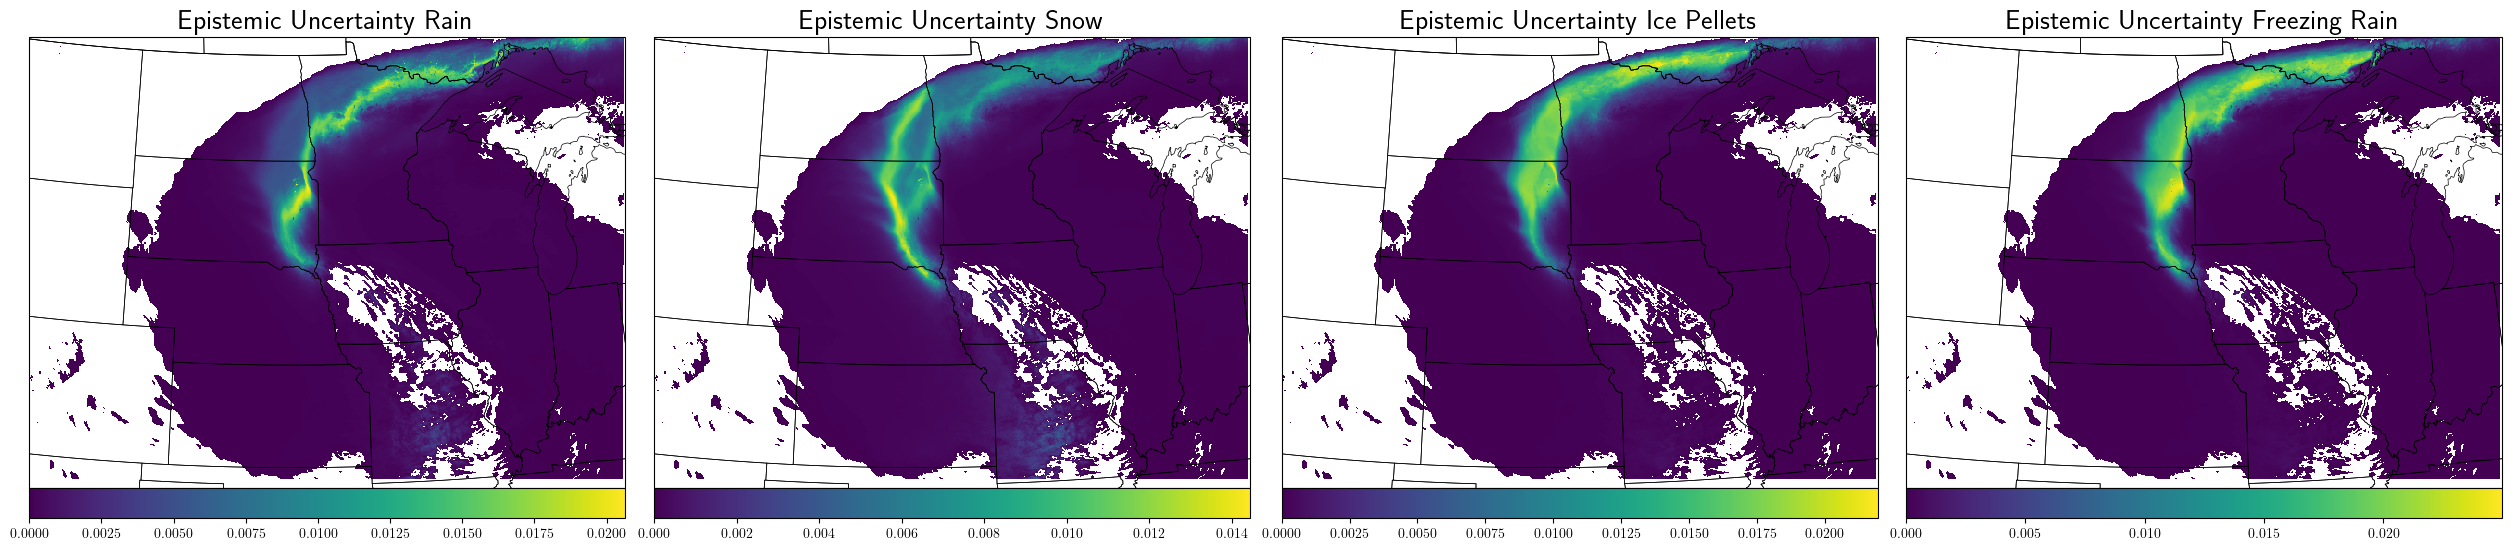

In [7]:
# 4 panel uncertainty plot:
crs = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
fig, axarr = plt.subplots(nrows=1, ncols=4, figsize=(25, 7), constrained_layout=True,
        subplot_kw={'projection': crs})
axlist = axarr.flatten()
for ax in axlist:
    plot_background(ax)

lat = data['latitude'].values
lon = data['longitude'].values

plt.rcParams['text.usetex'] = True

custom_colors = ['#f8f4f8', '#f005fc']
purples = mcolors.LinearSegmentedColormap.from_list("custom", custom_colors)

# top left: all ptypes:
cf0 = axlist[0].pcolormesh(lon, lat, data['ML_rain_epi'], transform=ccrs.PlateCarree(), cmap='viridis')
axlist[0].set_title("Epistemic Uncertainty Rain", fontsize=20)
cb0 = fig.colorbar(cf0, ax=axlist[0], orientation='horizontal', shrink=1, pad=0)

cf1 = axlist[1].pcolormesh(lon, lat, data['ML_snow_epi'], transform=ccrs.PlateCarree(), cmap='viridis')
axlist[1].set_title("Epistemic Uncertainty Snow", fontsize=20)
cf1 = fig.colorbar(cf1, ax=axlist[1], orientation='horizontal', pad=0)

cf2 = axlist[2].pcolormesh(lon, lat, data['ML_icep_epi'], transform=ccrs.PlateCarree(), cmap='viridis')
axlist[2].set_title("Epistemic Uncertainty Ice Pellets", fontsize=20)
fig.colorbar(cf2, ax=axlist[2], orientation='horizontal', pad=0)

cf3 = axlist[3].pcolormesh(lon, lat, data['ML_frzr_epi'], transform=ccrs.PlateCarree(), cmap='viridis')
axlist[3].set_title("Epistemic Uncertainty Freezing Rain", fontsize=20)
fig.colorbar(cf3, ax=axlist[3], orientation='horizontal', pad=0)

#plt.tight_layout()
plt.savefig("./plots/Uncertainty_plots4.png", dpi=300)

In [23]:
# another day:
valid_time = '2024-03-24 0800'
base_path = '/glade/campaign/cisl/aiml/ptype_historical/winter_2023_2024_extended/no_winds/hrrr'
n_members = 1

files = get_tle_files(base_path, valid_time, n_members)

In [24]:
data = load_ensemble(files)

In [27]:
data = xr.load_dataset(files[0]).squeeze()
ds = data
ptypes = ['rain', 'snow', 'frzr', 'icep']
precip_sum = ds[['crain', 'csnow', 'cicep', 'cfrzr']].to_array().sum(dim='variable')
for ptype in ptypes:
    ds[f'ML_c{ptype}'] = xr.where(precip_sum >= 1, x=ds[f"ML_c{ptype}"], y=np.nan)
    ds[f'ML_{ptype}'] = xr.where(precip_sum >= 1, x=ds[f"ML_{ptype}"], y=np.nan)
    ds[f'ML_{ptype}_epi'] = xr.where(precip_sum >= 1, x=ds[f"ML_{ptype}_epi"], y=np.nan)
    ds[f'ML_{ptype}_ale'] = xr.where(precip_sum >= 1, x=ds[f"ML_{ptype}_ale"], y=np.nan)
    ds[ptype] = ds[f'ML_c{ptype}'].where(ds[f'ML_c{ptype}'] >= 1) * ds[f'ML_{ptype}']  # evidential classification scaled by probability
    ds[f'c{ptype}'] = xr.where(ds[f'c{ptype}'] == 1, 1, np.nan)  # convert 0s to nans for plotting purposes

In [ ]:
crs = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
fig, ax = plt.subplots(figsize=(20, 13), subplot_kw={'projection': crs})
plot_background(ax, [-109.5, -87, 36, 49])

lat = data['latitude'].values
lon = data['longitude'].values

# top left: all ptypes:
custom_colors = ['#f8f4f8', '#f005fc']
purples = mcolors.LinearSegmentedColormap.from_list("custom", custom_colors)
cmaps = ['Greens', 'Blues', 'Reds', purples]
ptypes = ['rain', 'snow', 'frzr', 'icep']
for i, ptype in enumerate(ptypes):
    h = ax.pcolormesh(lon, lat, data[f'{ptype}'], transform=ccrs.PlateCarree(), cmap=cmaps[i], vmin=0, vmax=1)

plt.rcParams['text.usetex'] = True
ax.set_title(r"\textbf{Precipitation Types, Surface Temp, 10m Winds}", fontsize=22)

# Add legend
legend_handles = [mpatches.Patch(color=plt.get_cmap(cmaps[i])(0.6), label=ptype) for i, ptype in enumerate(ptypes)]
ax.legend(handles=legend_handles, loc='upper right', title='Precipitation Types', fontsize=20, title_fontsize=22, frameon=True, framealpha=1, fancybox=True)

# add temp contours
#temp_data = data['t2m'].mean("time") - 273.15
# Apply Gaussian smoothing
#smoothed_temp = gaussian_filter(temp_data, sigma=2)
#contour_temp(ax, lon, lat, smoothed_temp)

# add wind barbs:
#u = data['u10'].mean("time").values
#v = data['v10'].mean("time").values
#ax.barbs(lon[::20, ::20], lat[::20, ::20], u[::20, ::20], v[::20, ::20], length=6, linewidth=1, transform=ccrs.PlateCarree())

plt.tight_layout()
plt.savefig("./plots/2024-03-24_0700_ptype_1.png", dpi=300)

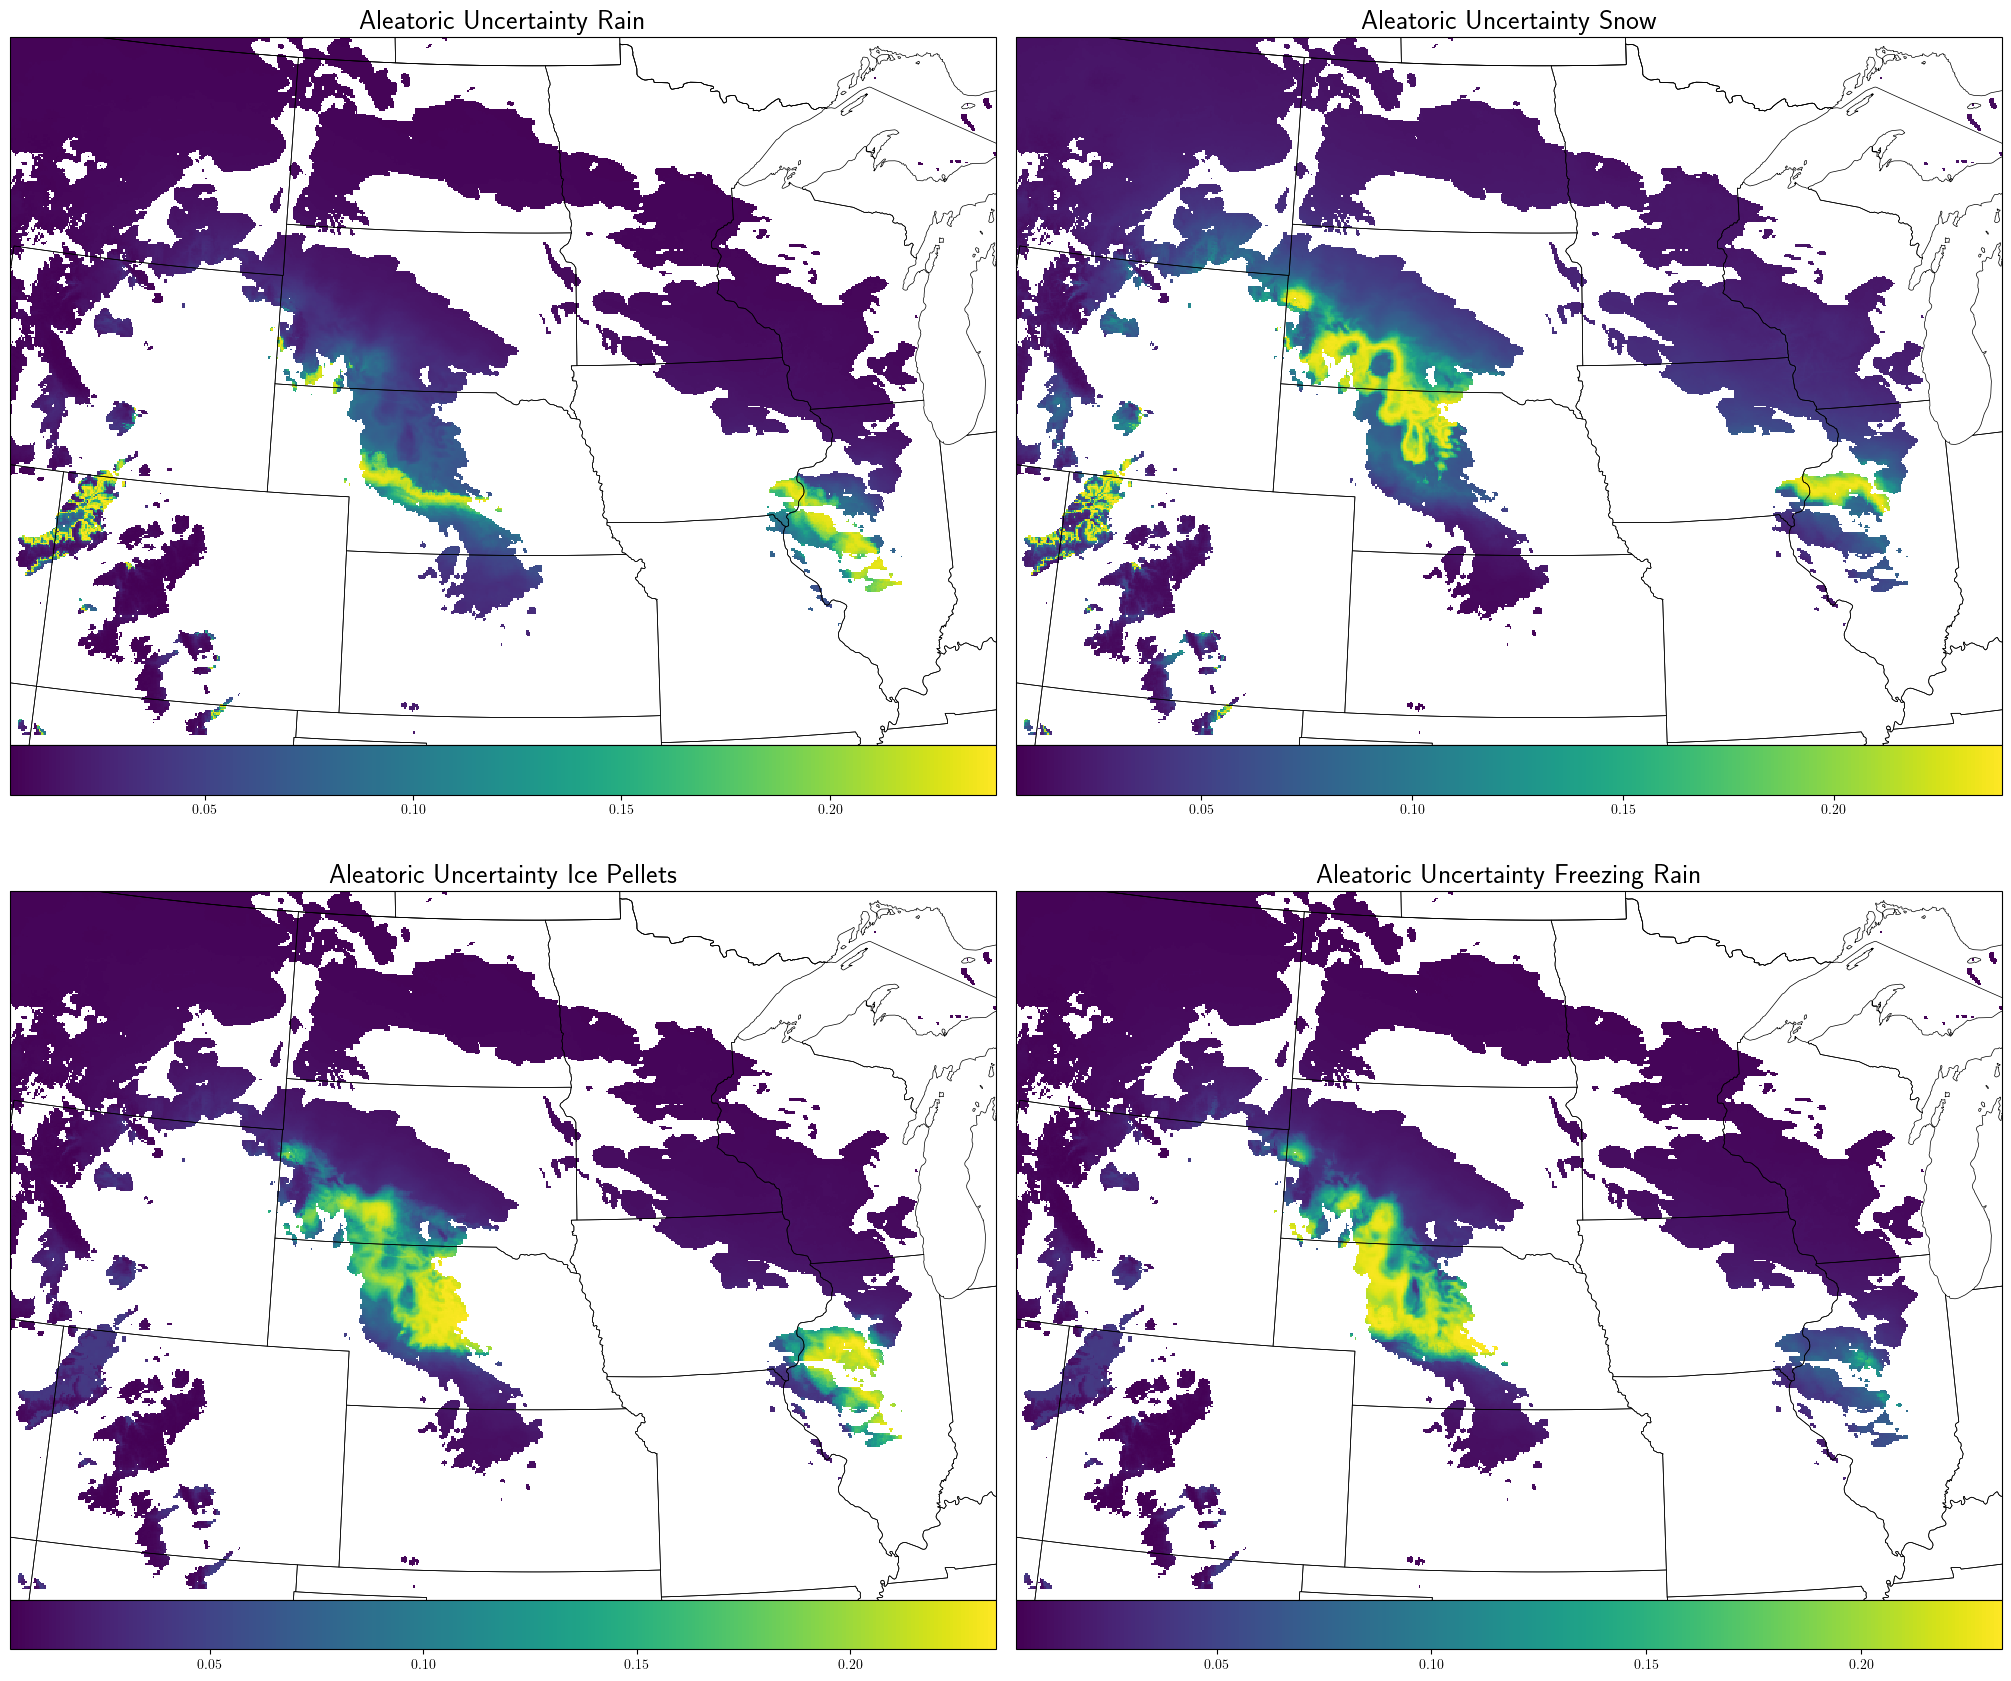

In [31]:
# 4 panel uncertainty plot:
crs = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(20, 17), constrained_layout=True,
        subplot_kw={'projection': crs})
axlist = axarr.flatten()
for ax in axlist:
    plot_background(ax, [-109.5, -87, 36, 49])

lat = data['latitude'].values
lon = data['longitude'].values

plt.rcParams['text.usetex'] = True

custom_colors = ['#f8f4f8', '#f005fc']
purples = mcolors.LinearSegmentedColormap.from_list("custom", custom_colors)

# top left: all ptypes:
cf0 = axlist[0].pcolormesh(lon, lat, data['ML_rain_ale'], transform=ccrs.PlateCarree(), cmap='viridis')
axlist[0].set_title("Aleatoric Uncertainty Rain", fontsize=20)
cb0 = fig.colorbar(cf0, ax=axlist[0], orientation='horizontal', shrink=1, pad=0)

cf1 = axlist[1].pcolormesh(lon, lat, data['ML_snow_ale'], transform=ccrs.PlateCarree(), cmap='viridis')
axlist[1].set_title("Aleatoric Uncertainty Snow", fontsize=20)
cf1 = fig.colorbar(cf1, ax=axlist[1], orientation='horizontal', pad=0)

cf2 = axlist[2].pcolormesh(lon, lat, data['ML_icep_ale'], transform=ccrs.PlateCarree(), cmap='viridis')
axlist[2].set_title("Aleatoric Uncertainty Ice Pellets", fontsize=20)
fig.colorbar(cf2, ax=axlist[2], orientation='horizontal', pad=0)

cf3 = axlist[3].pcolormesh(lon, lat, data['ML_frzr_ale'], transform=ccrs.PlateCarree(), cmap='viridis')
axlist[3].set_title("Aleatoric Uncertainty Freezing Rain", fontsize=20)
fig.colorbar(cf3, ax=axlist[3], orientation='horizontal', pad=0)

#plt.tight_layout()
plt.savefig("./plots/2024-03-24_0700_uncertainty_ale_plots.png", dpi=300)

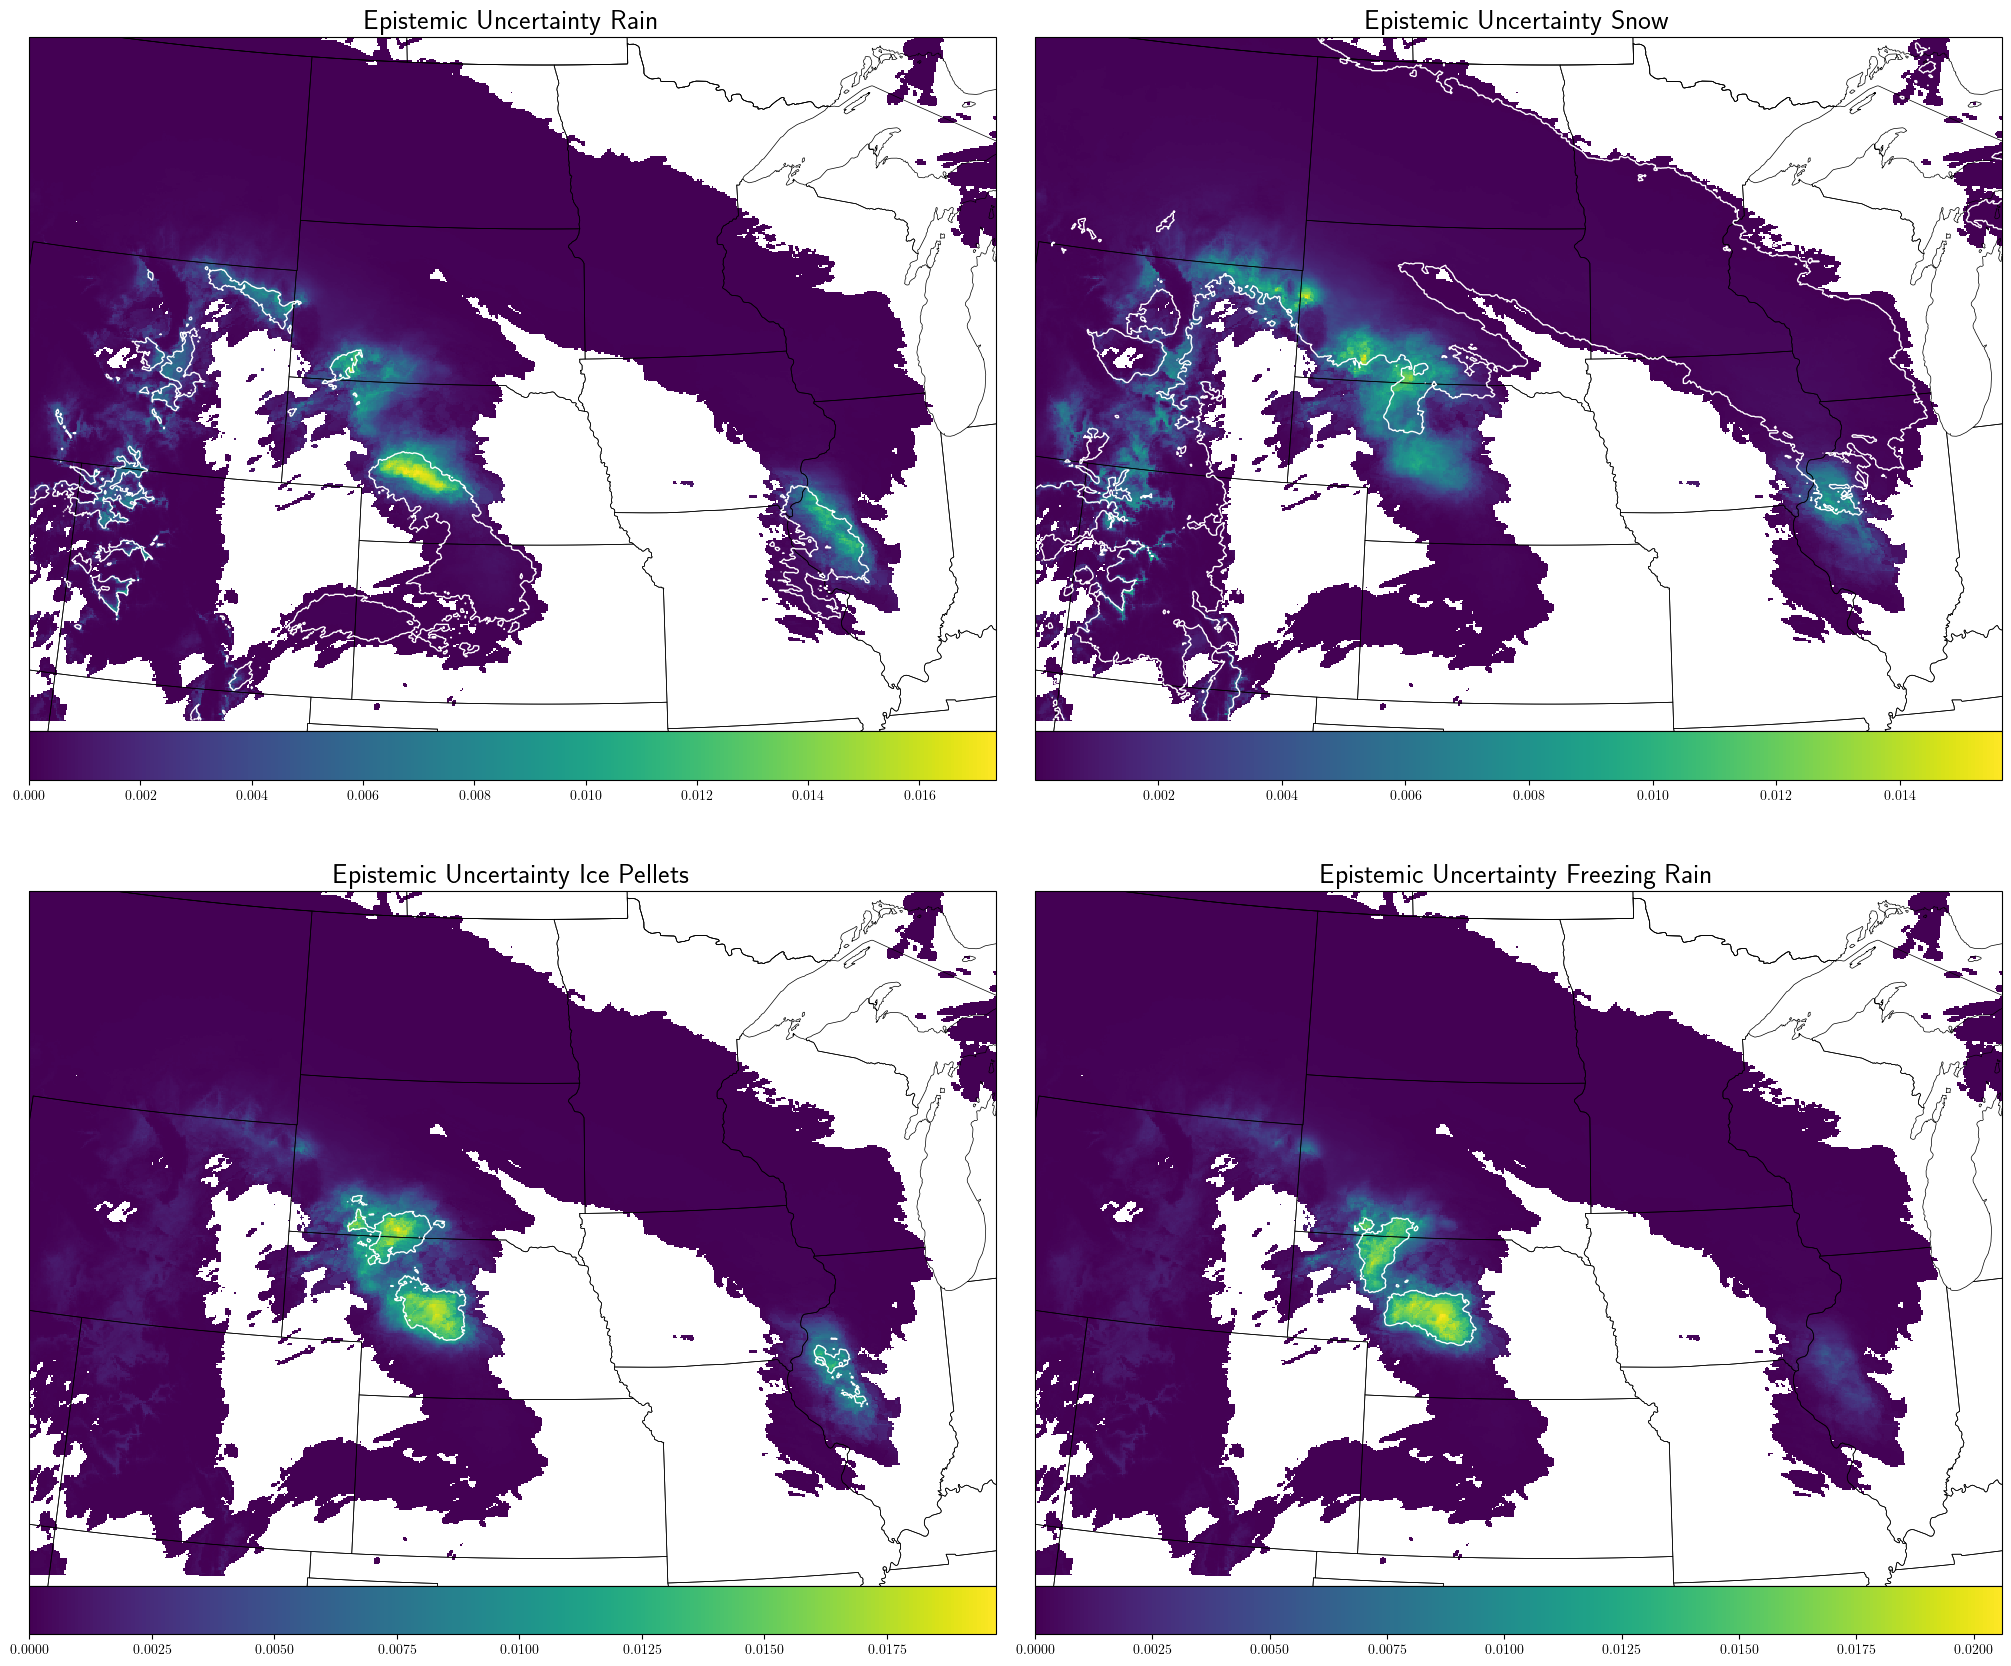

In [77]:
# 4 panel uncertainty plot:
crs = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(20, 17), constrained_layout=True,
        subplot_kw={'projection': crs})
axlist = axarr.flatten()
for ax in axlist:
    plot_background(ax, [-109.5, -87, 36, 49])

lat = data['latitude'].values
lon = data['longitude'].values

plt.rcParams['text.usetex'] = True

custom_colors = ['#f8f4f8', '#f005fc']
purples = mcolors.LinearSegmentedColormap.from_list("custom", custom_colors)

# top left: all ptypes:
cf0 = axlist[0].pcolormesh(lon, lat, data['ML_rain_epi'], transform=ccrs.PlateCarree(), cmap='viridis')
axlist[0].set_title("Epistemic Uncertainty Rain", fontsize=20)
cb0 = fig.colorbar(cf0, ax=axlist[0], orientation='horizontal', shrink=1, pad=0)
axlist[0].contour(lon, lat, data['ML_crain'].values, transform=ccrs.PlateCarree(), colors='black', linewidths=1)
contour_levels = [0.2]  # Contour level between 0 and 1
cs_rain = axlist[0].contour(lon, lat, data['ML_rain'].values, levels=contour_levels, colors='white', transform=ccrs.PlateCarree(), linewidths=1)


cf1 = axlist[1].pcolormesh(lon, lat, data['ML_snow_epi'], transform=ccrs.PlateCarree(), cmap='viridis')
axlist[1].set_title("Epistemic Uncertainty Snow", fontsize=20)
cf1 = fig.colorbar(cf1, ax=axlist[1], orientation='horizontal', pad=0)
cs_snow = axlist[1].contour(lon, lat, data['ML_snow'].values, levels=contour_levels, colors='white', transform=ccrs.PlateCarree(), linewidths=1)

cf2 = axlist[2].pcolormesh(lon, lat, data['ML_icep_epi'], transform=ccrs.PlateCarree(), cmap='viridis')
axlist[2].set_title("Epistemic Uncertainty Ice Pellets", fontsize=20)
fig.colorbar(cf2, ax=axlist[2], orientation='horizontal', pad=0)
cs_icep = axlist[2].contour(lon, lat, data['ML_icep'].values, levels=contour_levels, colors='white', transform=ccrs.PlateCarree(), linewidths=1)

cf3 = axlist[3].pcolormesh(lon, lat, data['ML_frzr_epi'], transform=ccrs.PlateCarree(), cmap='viridis')
axlist[3].set_title("Epistemic Uncertainty Freezing Rain", fontsize=20)
fig.colorbar(cf3, ax=axlist[3], orientation='horizontal', pad=0)
cs_frzr = axlist[3].contour(lon, lat, data['ML_frzr'].values, levels=contour_levels, colors='white', transform=ccrs.PlateCarree(), linewidths=1)

#plt.tight_layout()
plt.savefig("./plots/2024-03-24_0700_uncertainty_prob_contour2.png", dpi=300)

In [44]:
data['ML_crain'].values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [ 1.,  1.,  1., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [2]:
qc2 = pd.read_parquet("/glade/p/cisl/aiml/ai2es/winter_ptypes/ptype_qc/mPING_hourafter_interpolated_QC2.parquet")

In [3]:
qc3 = pd.read_parquet("/glade/work/sreiner/mPING_hourafter_interpolated_QC3.parquet")

In [5]:
df = qc2
c1 = df["ra_percent"] == 1.0
c2 = df["sn_percent"] == 1.0
c3 = df["pl_percent"] == 1.0
c4 = df["fzra_percent"] == 1.0
condition = c1 | c2 | c3 | c4
df = df[condition].copy()

qc_value = 3.0
cond1 = df[f"wetbulb{qc_value}_filter"] == 0.0
cond2 = df["usa"] == 1.0
dg = df[cond1 & cond2].copy()

In [6]:
df = qc3
c1 = df["ra_percent"] == 1.0
c2 = df["sn_percent"] == 1.0
c3 = df["pl_percent"] == 1.0
c4 = df["fzra_percent"] == 1.0
condition = c1 | c2 | c3 | c4
df = df[condition].copy()

qc_value = 3.0
cond1 = df[f"wetbulb{qc_value}_filter"] == 0.0
cond2 = df["usa"] == 1.0
dg3 = df[cond1 & cond2].copy()

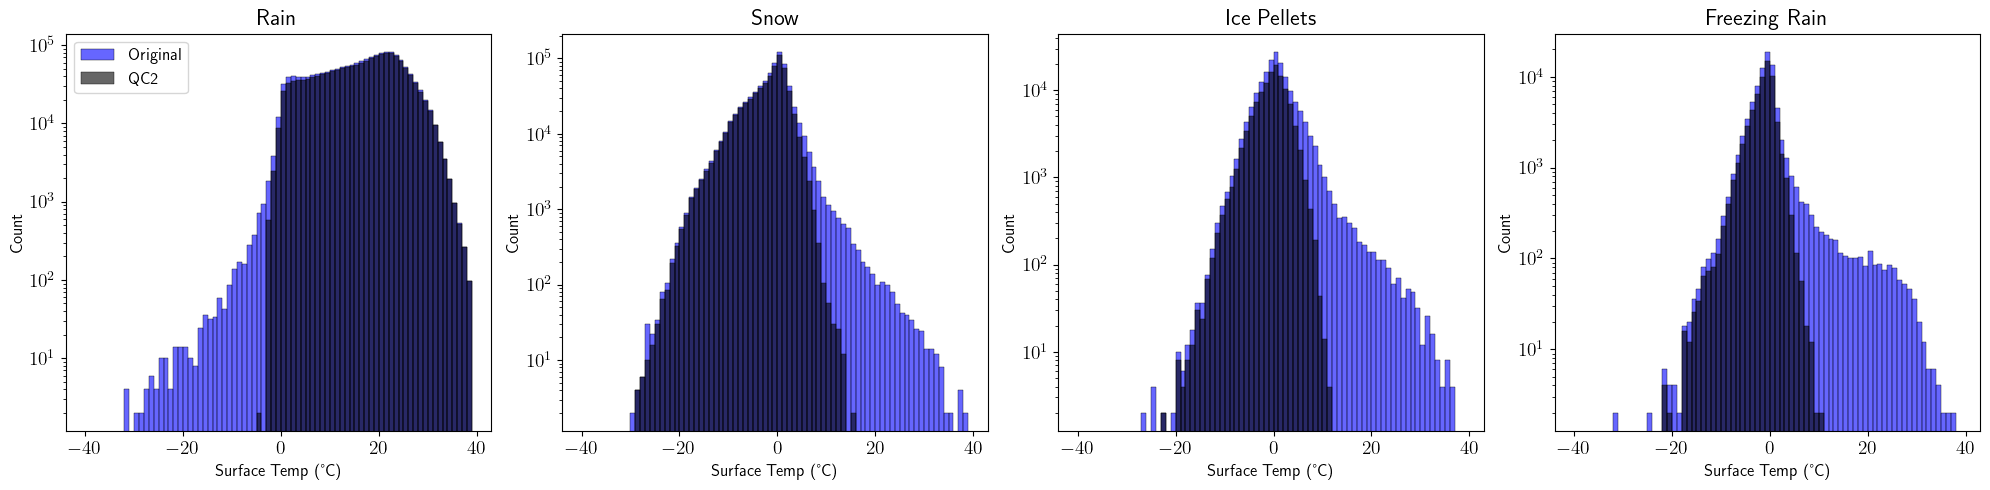

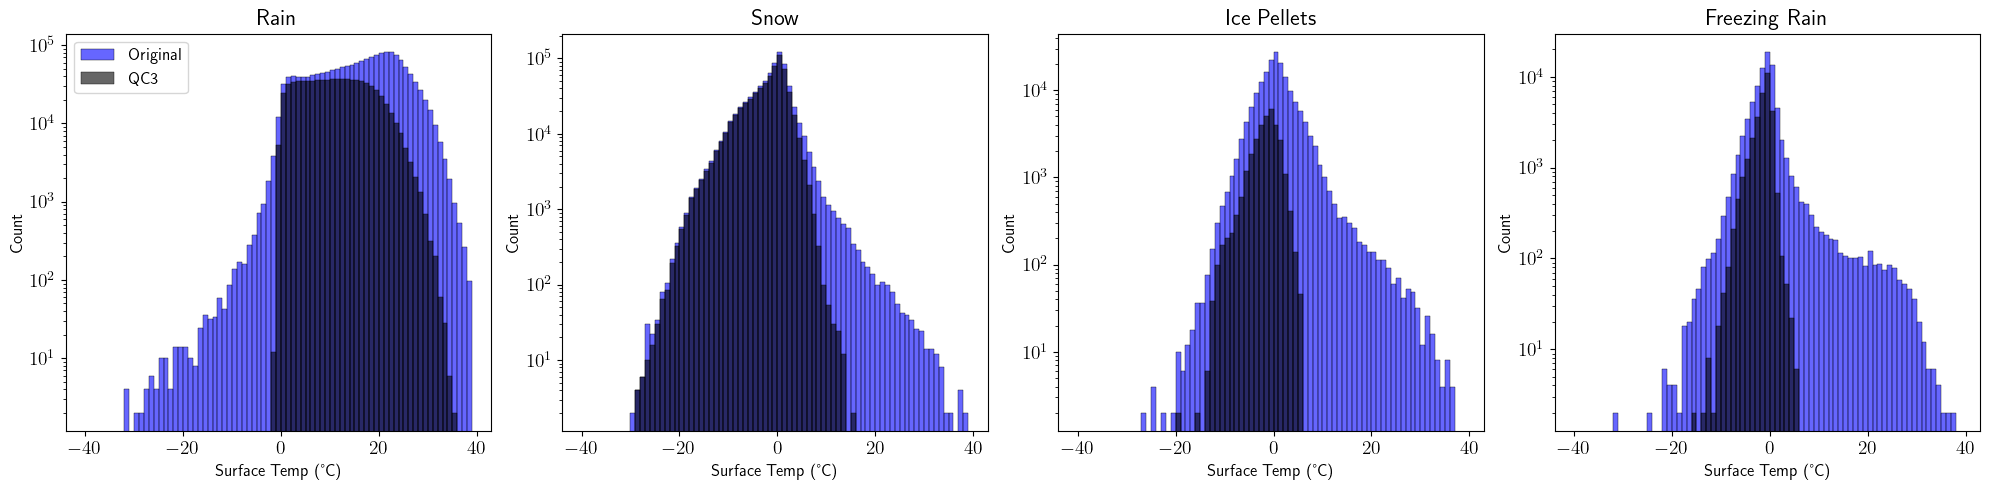

In [51]:
data = qc2
col = 'TEMP_C_0_m'
name = '0m_temp'
bins = np.arange(-40, 40, 1)
dfs = [dg, dg3]
classes = ['Rain', 'Snow', 'Ice Pellets', 'Freezing Rain']
qc_names = ['QC2', 'QC3']
path = './plots/'
save_paths = [f"{path}{name}_QC2hist.png", f"{path}{name}_QC3hist.png"]

for i, df in enumerate(dfs):
    qc_ra = df[col][df['ra_percent'] > 0.0]
    qc_sn = df[col][df['sn_percent'] > 0.0]
    qc_pl = df[col][df['pl_percent'] > 0.0]
    qc_fzra = df[col][df['fzra_percent'] > 0.0]
    qc_ptypes = [qc_ra, qc_sn, qc_pl, qc_fzra]
    
    ra = data[col][data['ra_percent'] > 0.0]
    sn = data[col][data['sn_percent'] > 0.0]
    pl = data[col][data['pl_percent'] > 0.0]
    fzra = data[col][data['fzra_percent'] > 0.0]
    ptypes = [ra, sn, pl, fzra]
    
    fig, ax = plt.subplots(1, 4, figsize=(20, 5), tight_layout=True)
    plt.rcParams['text.usetex'] = True
    
    for j in range(len(ptypes)):
        sns.histplot(ptypes[j], bins=bins, label="Original", ax=ax[j], color='blue', stat='count', alpha=0.6)
        sns.histplot(qc_ptypes[j], bins=bins, ax=ax[j], color='black', label=f"{qc_names[i]}", stat='count', alpha=0.6)
        ax[j].set_yscale('log')
        ax[j].set_xlabel(r"Surface Temp (\textdegree C)", fontsize=12)
        ax[j].set_ylabel("Count", fontsize=12)
        ax[j].tick_params(axis='x', labelsize=14)
        ax[j].tick_params(axis='y', labelsize=14)
        ax[j].set_title(f"{classes[j]}", fontsize=16)
        if j == 0:
            ax[j].legend(fontsize=12)
    
    plt.savefig(save_paths[i], dpi=300, bbox_inches="tight")

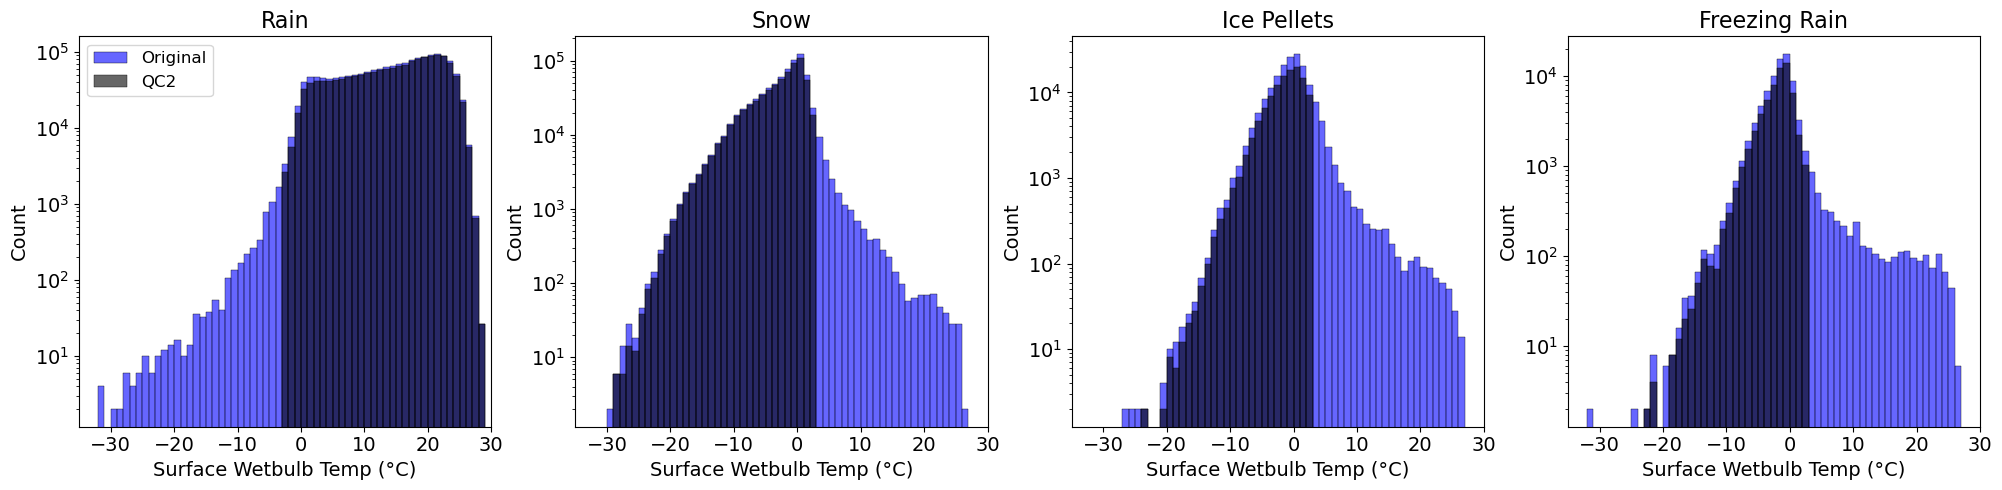

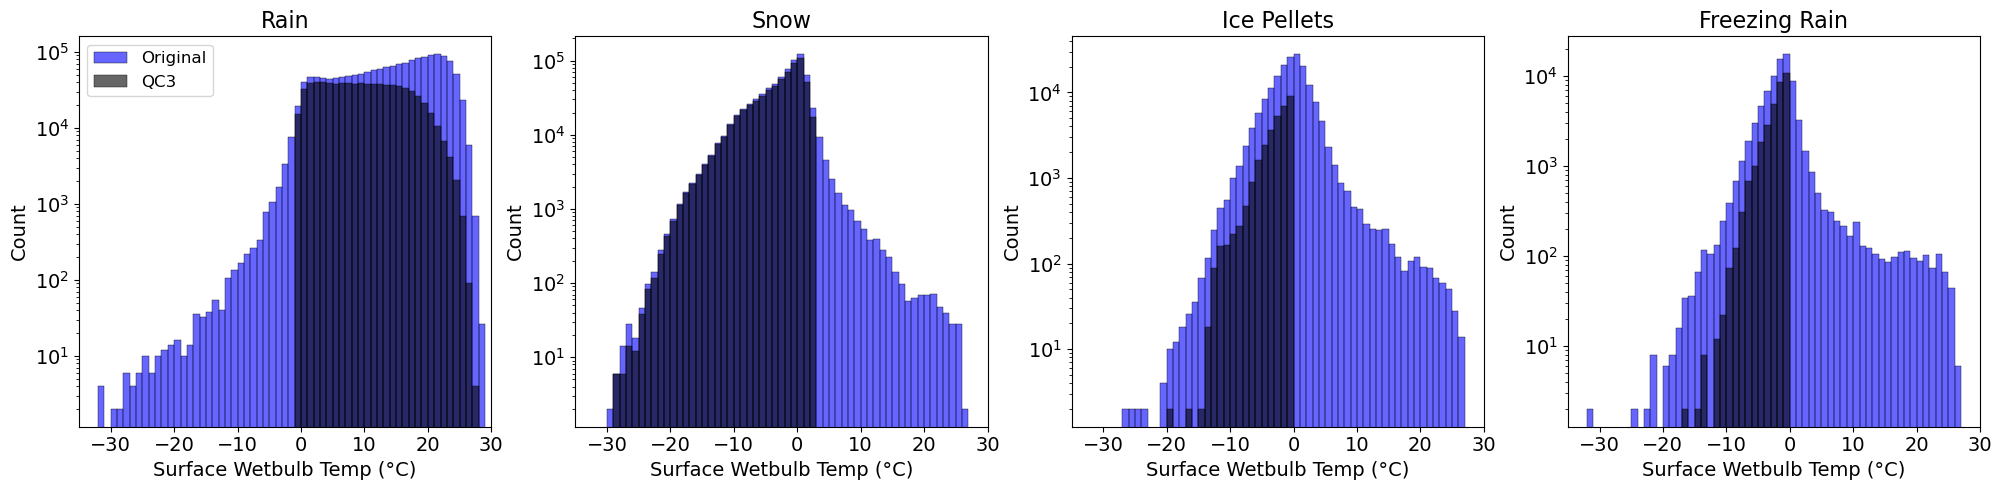

In [15]:
import seaborn as sns
data = qc2
col = 'wetbulb_temp_0m_C'
name = '0m_wetbulb_temp'
bins = np.arange(-40, 40, 1)
dfs = [dg, dg3]
classes = ['Rain', 'Snow', 'Ice Pellets', 'Freezing Rain']
qc_names = ['QC2', 'QC3']
path = './plots/'
save_paths = [f"{path}{name}_QC2hist_notex.png", f"{path}{name}_QC3hist_notex.png"]

for i, df in enumerate(dfs):
    qc_ra = df[col][df['ra_percent'] > 0.0]
    qc_sn = df[col][df['sn_percent'] > 0.0]
    qc_pl = df[col][df['pl_percent'] > 0.0]
    qc_fzra = df[col][df['fzra_percent'] > 0.0]
    qc_ptypes = [qc_ra, qc_sn, qc_pl, qc_fzra]
    
    ra = data[col][data['ra_percent'] > 0.0]
    sn = data[col][data['sn_percent'] > 0.0]
    pl = data[col][data['pl_percent'] > 0.0]
    fzra = data[col][data['fzra_percent'] > 0.0]
    ptypes = [ra, sn, pl, fzra]
    
    fig, ax = plt.subplots(1, 4, figsize=(20, 5), tight_layout=True)
    plt.rcParams['text.usetex'] = False
    
    for j in range(len(ptypes)):
        sns.histplot(ptypes[j], bins=bins, label="Original", ax=ax[j], color='blue', stat='count', alpha=0.6)
        sns.histplot(qc_ptypes[j], bins=bins, ax=ax[j], color='black', label=f"{qc_names[i]}", stat='count', alpha=0.6)
        ax[j].set_yscale('log')
        ax[j].set_xlabel(r"Surface Wetbulb Temp (°C)", fontsize=14)
        ax[j].set_ylabel("Count", fontsize=14)
        ax[j].set_xlim(-35, 30)
        ax[j].tick_params(axis='x', labelsize=14)
        ax[j].tick_params(axis='y', labelsize=14)
        ax[j].set_title(f"{classes[j]}", fontsize=16)
        if j == 0:
            ax[j].legend(fontsize=12)
    
    plt.savefig(save_paths[i], dpi=300, bbox_inches="tight")

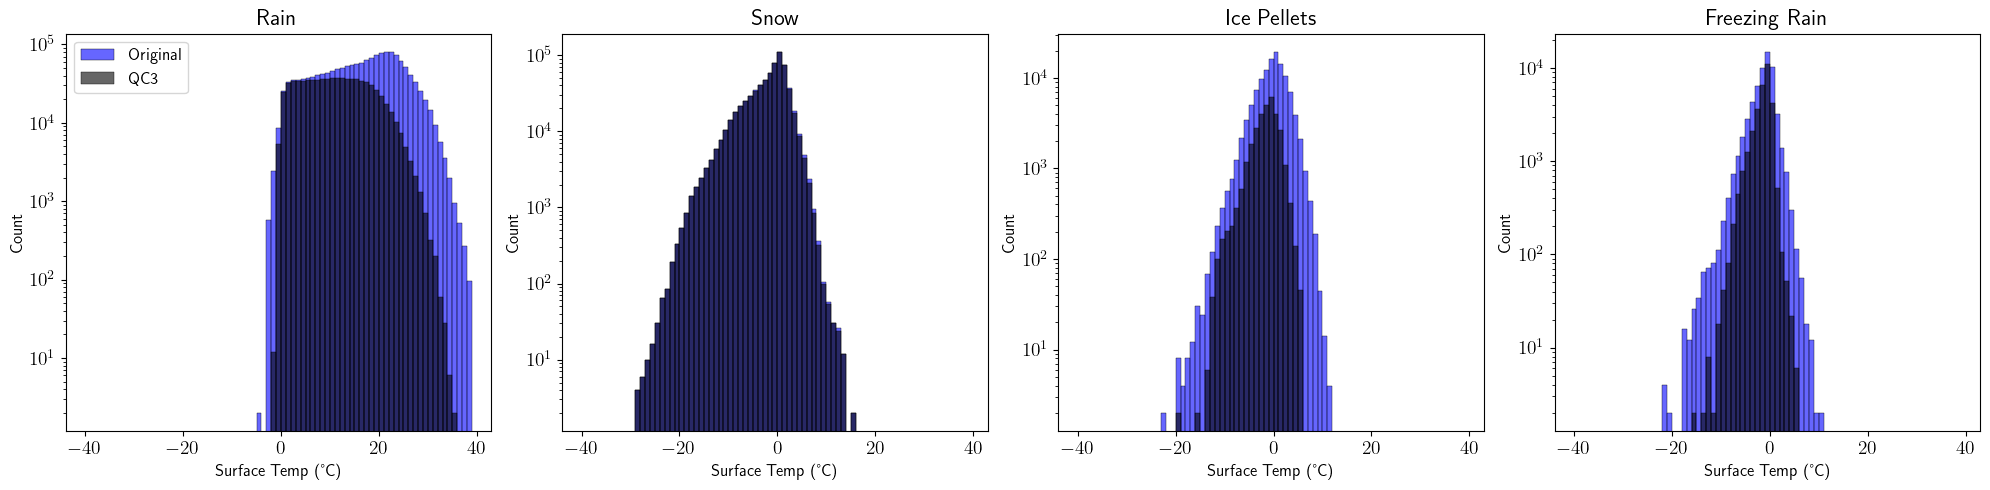

In [49]:
data = dg
col = 'TEMP_C_0_m'
name = '0m_temp'
bins = np.arange(-40, 40, 1)
dfs = [dg3]
classes = ['Rain', 'Snow', 'Ice Pellets', 'Freezing Rain']
qc_names = ['QC3']
path = './plots/'
save_paths = [f"{path}{name}_QC3hist_horiz.png"]

for i, df in enumerate(dfs):
    qc_ra = df[col][df['ra_percent'] > 0.0]
    qc_sn = df[col][df['sn_percent'] > 0.0]
    qc_pl = df[col][df['pl_percent'] > 0.0]
    qc_fzra = df[col][df['fzra_percent'] > 0.0]
    qc_ptypes = [qc_ra, qc_sn, qc_pl, qc_fzra]
    
    ra = data[col][data['ra_percent'] > 0.0]
    sn = data[col][data['sn_percent'] > 0.0]
    pl = data[col][data['pl_percent'] > 0.0]
    fzra = data[col][data['fzra_percent'] > 0.0]
    ptypes = [ra, sn, pl, fzra]
        
    fig, ax = plt.subplots(1, 4, figsize=(20, 5), tight_layout=True)
    plt.rcParams['text.usetex'] = True
    
    for j in range(len(ptypes)):
        sns.histplot(ptypes[j], bins=bins, label="Original", ax=ax[j], color='blue', stat='count', alpha=0.6)
        sns.histplot(qc_ptypes[j], bins=bins, ax=ax[j], color='black', label=f"{qc_names[i]}", stat='count', alpha=0.6)
        ax[j].set_yscale('log')
        ax[j].set_xlabel(r"Surface Temp (\textdegree C)", fontsize=12)
        ax[j].set_ylabel("Count", fontsize=12)
        ax[j].tick_params(axis='x', labelsize=14)
        ax[j].tick_params(axis='y', labelsize=14)
        ax[j].set_title(f"{classes[j]}", fontsize=16)
        if j == 0:
            ax[j].legend(fontsize=12)
            
    plt.savefig(save_paths[i], dpi=300, bbox_inches="tight")

In [87]:
d = xr.open_dataset(files[0]).squeeze().reset_coords()

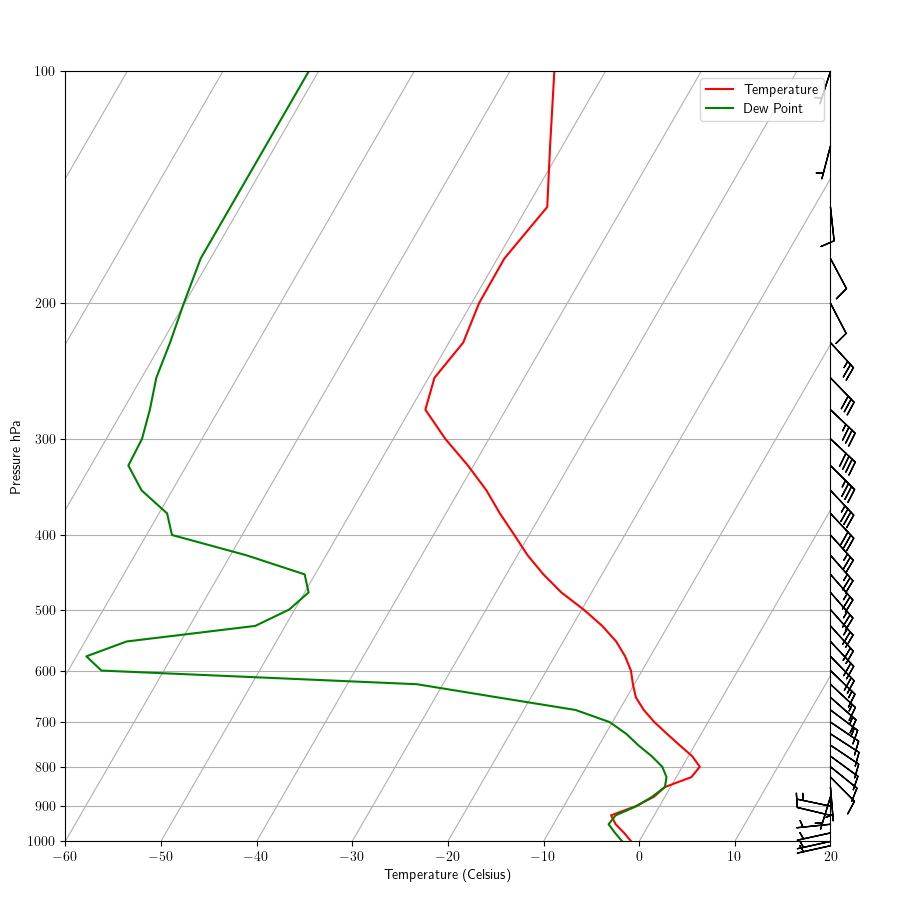

In [95]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

# Sample data (replace with your actual HRRR data)

# Convert data to appropriate units
height = d['heightAboveGround'].values * units.meter
pressure = df['isobaricInhPa'].values * units.hPa
temperature = d['t'][:, 208, 418].values * units.degC
dew_point = df['dpt'][:, 208, 418].values * units.degC
u_wind = df['u'][:, 208, 418].values * units.meter / units.second
v_wind = df['v'][:, 208, 418].values * units.meter / units.second

# Calculate wind speed and direction
wind_speed = mpcalc.wind_speed(u_wind, v_wind)
wind_direction = mpcalc.wind_direction(u_wind, v_wind)

# Create the SkewT plot
fig = plt.figure(figsize=(10, 10))
skew = SkewT(fig)

# Plot temperature and dew point
skew.plot(pressure, temperature, 'r', label='Temperature')
skew.plot(pressure, dew_point, 'g', label='Dew Point')

# Plot wind barbs
skew.plot_barbs(pressure, u_wind, v_wind)

# Add special lines
#skew.plot_dry_adiabats()
#skew.plot_moist_adiabats()
#skew.plot_mixing_lines()
skew.ax.set_xlim(-60, 20)  # Temperature range in Celsius
skew.ax.set_ylim(1000, 100)  # Pressure range in hPa (surface to tropopause)
skew.ax.set_xlabel("Temperature (Celsius)")
skew.ax.set_ylabel("Pressure hPa")
# Add legend
plt.legend(loc='best')

# Show the plot
plt.savefig("./plots/composite_skewT.png", dpi=300)
